<a href="https://colab.research.google.com/github/Maymontilhacotrim/MestradoPGEB/blob/main/74723Projeto_classificacao_remanescentes_florestais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Experimentos Machine Learning - Projeto de Classificação de Remanecentes Florestais**

**Equipe:**

Pesquisadora Mayara Montilha Cotrim

Orientadora Profa. Cristiane Nunes

Coorientador e autor Dr. Pedro Fernandes

Autor Jairson Aberto Sami

**Carregando bibliotecas**

In [ ]:
# instalar bibliotecas

!pip install rasterio
!pip install rioxarray
!pip install -U scikit-learn
!python -m pip show scikit-learn
!python -m pip freeze
!python -c "import sklearn; sklearn.show_versions()"
!pip install geopandas


# Limpar a saída da célula atual
from IPython.display import clear_output
clear_output()

import os
import sys
import csv
import time
import glob
import joblib
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!dir

drive  sample_data


**Extrair valores dos pixels**

In [ ]:
col = gpd.read_file('/content/drive/MyDrive/testclassifmay/AmostrasSemEucaliptoEconcertado.shp')
tif = rxr.open_rasterio('/content/drive/MyDrive/testclassifmay/b8.tif')

col.to_crs(tif.rio.crs)

,VALUE,geometry
0,1.0,MULTIPOINT (694504.5 7469044.5)
1,1.0,MULTIPOINT (694495.5 7469041.5)
2,1.0,MULTIPOINT (694498.5 7469041.5)
3,1.0,MULTIPOINT (694501.5 7469041.5)
4,1.0,MULTIPOINT (694504.5 7469041.5)
...,...,...
74718,1.0,MULTIPOINT (703525.5 7457647.5)
74719,1.0,MULTIPOINT (703528.5 7457647.5)
74720,1.0,MULTIPOINT (703519.5 7457644.5)
74721,1.0,MULTIPOINT (703522.5 7457644.5)


In [ ]:
print(col.crs)

EPSG:32723


In [ ]:
tif.rio.crs == col.crs

True

In [ ]:
# Caminho dos arquivos .TIF
path =  glob.glob('/content/drive/MyDrive/testclassifmay/*.tif')
path

['/content/drive/MyDrive/testclassifmay/b1.tif',
 '/content/drive/MyDrive/testclassifmay/b2.tif',
 '/content/drive/MyDrive/testclassifmay/b3.tif',
 '/content/drive/MyDrive/testclassifmay/b4.tif',
 '/content/drive/MyDrive/testclassifmay/b5.tif',
 '/content/drive/MyDrive/testclassifmay/b6.tif',
 '/content/drive/MyDrive/testclassifmay/b7.tif',
 '/content/drive/MyDrive/testclassifmay/b8.tif',
 '/content/drive/MyDrive/testclassifmay/b10.tif',
 '/content/drive/MyDrive/testclassifmay/b9.tif',
 '/content/drive/MyDrive/testclassifmay/b12.tif',
 '/content/drive/MyDrive/testclassifmay/b11.tif']

In [ ]:
# importar csv salvos na pasta data_drive

b1 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b1.csv')
b2 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b2.csv')
b3 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b3.csv')
b4 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b4.csv')
b5 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b5.csv')
b6 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b6.csv')
b7 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b7.csv')
b8 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b8.csv')
b9 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b9.csv')
b10 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b10.csv')
b11 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b11.csv')
b12 = pd.read_csv('/content/drive/MyDrive/testclassifmay/b12.csv')

# ler
b1.head()

,0
0,242.0
1,298.0
2,218.0
3,176.0
4,217.0


In [ ]:
# renomerar as colunas de cada dataFrame
b1 = b1.rename(columns={'0':'b1'})
b2 = b2.rename(columns={'0':'b2'})
b3 = b3.rename(columns={'0':'b3'})
b4 = b4.rename(columns={'0':'b4'})
b5 = b5.rename(columns={'0':'b5'})
b6 = b6.rename(columns={'0':'b6'})
b7 = b7.rename(columns={'0':'b7'})
b8 = b8.rename(columns={'0':'b8'})
b9 = b9.rename(columns={'0':'b9'})
b10 = b10.rename(columns={'0':'b10'})
b11 = b11.rename(columns={'0':'b11'})
b12 = b12.rename(columns={'0':'b12'})

In [ ]:
# juntar o data frame em único arquivo
df = pd.concat([b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12], axis=1)

#ler
df.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12
0,242.0,325.0,365.0,405.0,404.0,413.0,592.0,1264.0,-0.063525,41.506382,92.31239,5075
1,298.0,321.0,340.0,401.0,409.0,417.0,627.0,1347.0,-0.028929,35.466908,86.72642,5272
2,218.0,313.0,342.0,390.0,404.0,421.0,610.0,1300.0,-0.040612,38.512325,88.84723,5107
3,176.0,322.0,342.0,387.0,401.0,417.0,604.0,1252.0,-0.067338,37.830753,91.07682,5003
4,217.0,340.0,342.0,389.0,397.0,396.0,615.0,1225.0,-0.055637,38.691616,93.25843,5114


In [ ]:
# importar os pontos coletados
coletas_pontos = gpd.read_file('/content/drive/MyDrive/testclassifmay/AmostrasSemEucaliptoEconcertado.shp')
coletas_pontos.head()

,VALUE,geometry
0,1.0,MULTIPOINT (694504.5 7469044.5)
1,1.0,MULTIPOINT (694495.5 7469041.5)
2,1.0,MULTIPOINT (694498.5 7469041.5)
3,1.0,MULTIPOINT (694501.5 7469041.5)
4,1.0,MULTIPOINT (694504.5 7469041.5)


In [ ]:
# importar os pontos coletados
coletas_pontos = gpd.read_file('/content/drive/MyDrive/testclassifmay/AmostrasSemEucaliptoEconcertado.shp')
coletas_pontos.head()

,VALUE,geometry
0,1.0,MULTIPOINT (694504.5 7469044.5)
1,1.0,MULTIPOINT (694495.5 7469041.5)
2,1.0,MULTIPOINT (694498.5 7469041.5)
3,1.0,MULTIPOINT (694501.5 7469041.5)
4,1.0,MULTIPOINT (694504.5 7469041.5)


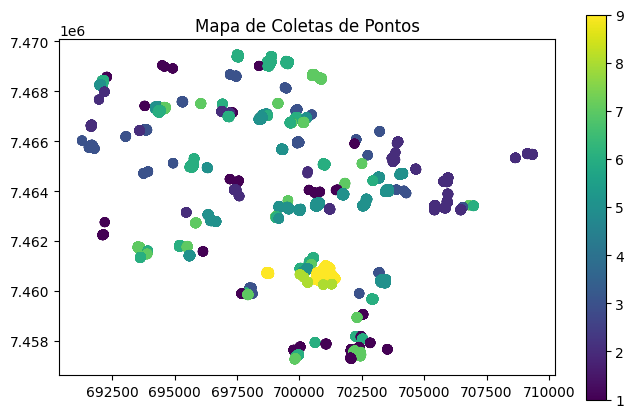

In [ ]:
# Visualizar os pontos coletados
fig, ax = plt.subplots(figsize=(8, 5))


coletas_pontos.plot(column='VALUE', legend=True, ax=ax)
ax.set_title('Mapa de Coletas de Pontos')

plt.show()

In [ ]:
# extrair só as classes de pontos coletados
concat = coletas_pontos[['VALUE']]
concat.head()

,VALUE
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [ ]:
# juntar com dataFrame df em único arquvo csv dfs

dfs = pd.concat([df, concat], axis=1)
dfs.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,VALUE
0,242.0,325.0,365.0,405.0,404.0,413.0,592.0,1264.0,-0.063525,41.506382,92.31239,5075,1.0
1,298.0,321.0,340.0,401.0,409.0,417.0,627.0,1347.0,-0.028929,35.466908,86.72642,5272,1.0
2,218.0,313.0,342.0,390.0,404.0,421.0,610.0,1300.0,-0.040612,38.512325,88.84723,5107,1.0
3,176.0,322.0,342.0,387.0,401.0,417.0,604.0,1252.0,-0.067338,37.830753,91.07682,5003,1.0
4,217.0,340.0,342.0,389.0,397.0,396.0,615.0,1225.0,-0.055637,38.691616,93.25843,5114,1.0


In [ ]:
dfs.to_csv('/content/drive/MyDrive/testclassifmay/arquivo_final_csv')

In [ ]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74723 entries, 0 to 74722
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   b1      74723 non-null  float64
 1   b2      74723 non-null  float64
 2   b3      74723 non-null  float64
 3   b4      74723 non-null  float64
 4   b5      74723 non-null  float64
 5   b6      74723 non-null  float64
 6   b7      74723 non-null  float64
 7   b8      74723 non-null  float64
 8   b9      74723 non-null  float64
 9   b10     74723 non-null  float64
 10  b11     74723 non-null  float64
 11  b12     74723 non-null  int64  
 12  VALUE   74723 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 7.4 MB


In [ ]:
dfs.isna().sum()

,0
b1,0
b2,0
b3,0
b4,0
b5,0
b6,0
b7,0
b8,0
b9,0
b10,0


array([[<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b2'}>,
        <Axes: title={'center': 'b3'}>, <Axes: title={'center': 'b4'}>],
       [<Axes: title={'center': 'b5'}>, <Axes: title={'center': 'b6'}>,
        <Axes: title={'center': 'b7'}>, <Axes: title={'center': 'b8'}>],
       [<Axes: title={'center': 'b9'}>, <Axes: title={'center': 'b10'}>,
        <Axes: title={'center': 'b11'}>, <Axes: title={'center': 'b12'}>],
       [<Axes: title={'center': 'VALUE'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

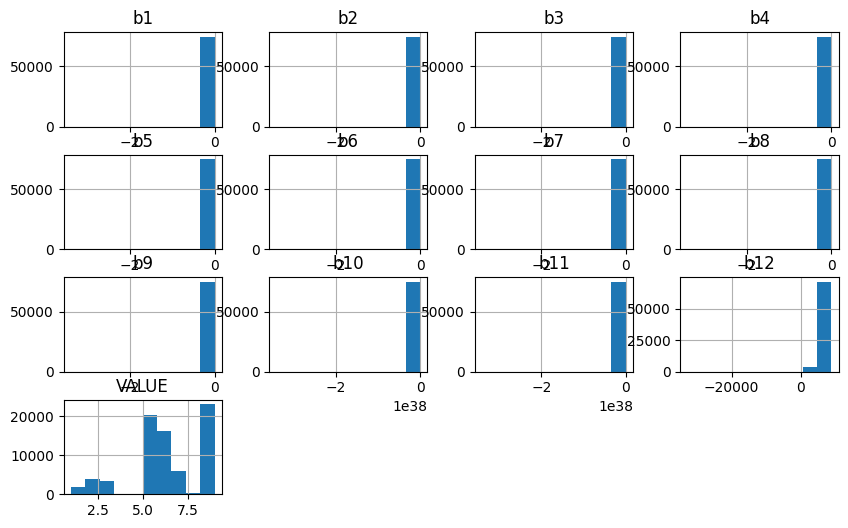

In [ ]:
dfs.hist(figsize=(10, 6))

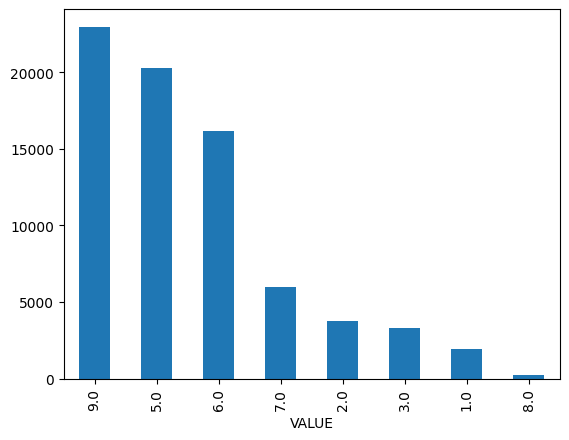

In [ ]:
y = dfs['VALUE']
X = dfs.drop(columns=['VALUE'])
y.value_counts().plot(kind="bar")
plt.show()

In [ ]:
dfs.loc[dfs['VALUE'] == 'afloramento', 'VALUE'] = 1
dfs.loc[dfs['VALUE'] == 'campo', 'VALUE'] = 2
dfs.loc[dfs['VALUE'] == 'Edificação', 'VALUE'] = 3
dfs.loc[dfs['VALUE'] == 'FlorestaA', 'VALUE'] = 5
dfs.loc[dfs['VALUE'] == 'FlorestaM', 'VALUE'] = 6
dfs.loc[dfs['VALUE'] == 'FlorestaB', 'VALUE'] = 7
dfs.loc[dfs['VALUE'] == 'Agua', 'VALUE'] = 8
dfs.loc[dfs['VALUE'] == 'AreaUmida', 'VALUE'] = 9

In [ ]:
dfs = dfs.dropna()
dfs.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,VALUE
0,242.0,325.0,365.0,405.0,404.0,413.0,592.0,1264.0,-0.063525,41.506382,92.31239,5075,1.0
1,298.0,321.0,340.0,401.0,409.0,417.0,627.0,1347.0,-0.028929,35.466908,86.72642,5272,1.0
2,218.0,313.0,342.0,390.0,404.0,421.0,610.0,1300.0,-0.040612,38.512325,88.84723,5107,1.0
3,176.0,322.0,342.0,387.0,401.0,417.0,604.0,1252.0,-0.067338,37.830753,91.07682,5003,1.0
4,217.0,340.0,342.0,389.0,397.0,396.0,615.0,1225.0,-0.055637,38.691616,93.25843,5114,1.0


**Machine Learning**

In [ ]:
!pip install yellowbrick

In [ ]:
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import (
    make_scorer, accuracy_score, balanced_accuracy_score, average_precision_score, brier_score_loss, f1_score,
    log_loss, precision_score, recall_score, jaccard_score, roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, auc,
)

In [ ]:
# Separando o conjunto de dados em features (X) e variável alvo (y)

X, y = dfs.drop(columns=['VALUE']), dfs['VALUE']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
# Convertendo os conjuntos de treinamento e teste para tipos de dados específicos

X_train = X_train.astype('float')
X_test = X_test.astype('float')

# Handle non-finite values in y_train before conversion
#y_train = y_train.fillna(0).astype('int')  # Replace NaN with 0, then convert to int

#y_test = y_test.astype('float')

<ipython-input-30-6299301672ed>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_class_counts.index, y=train_class_counts.values, ax=ax[0], palette="viridis")
<ipython-input-30-6299301672ed>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_class_counts.index, y=test_class_counts.values, ax=ax[1], palette="viridis")


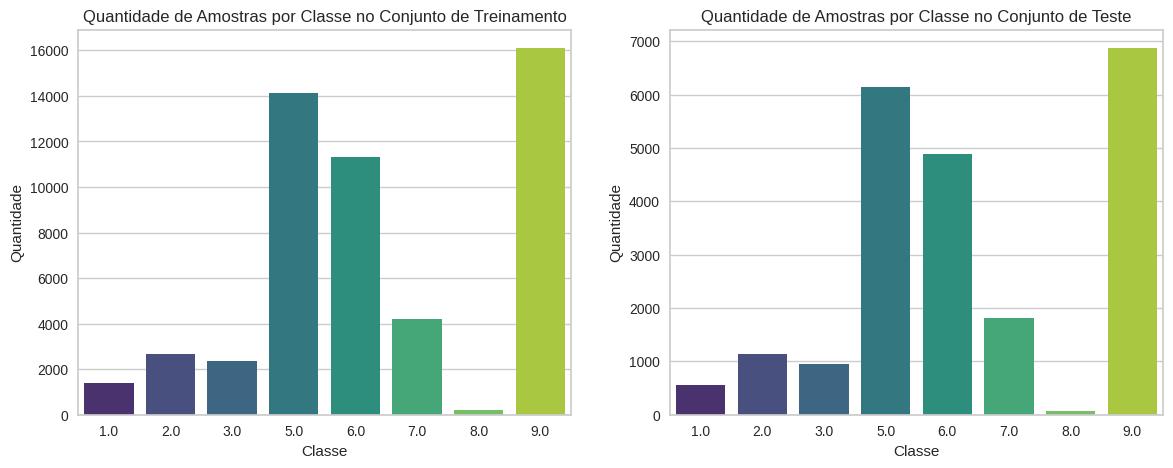

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Conte a quantidade de amostras por classe no conjunto de treinamento
train_class_counts = y_train.value_counts()

# Conte a quantidade de amostras por classe no conjunto de teste
test_class_counts = y_test.value_counts()

# Plote as contagens das classes
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot para o conjunto de treinamento
sns.barplot(x=train_class_counts.index, y=train_class_counts.values, ax=ax[0], palette="viridis")
ax[0].set_title('Quantidade de Amostras por Classe no Conjunto de Treinamento')
ax[0].set_xlabel('Classe')
ax[0].set_ylabel('Quantidade')

# Plot para o conjunto de teste
sns.barplot(x=test_class_counts.index, y=test_class_counts.values, ax=ax[1], palette="viridis")
ax[1].set_title('Quantidade de Amostras por Classe no Conjunto de Teste')
ax[1].set_xlabel('Classe')
ax[1].set_ylabel('Quantidade')

plt.show()

**Random Forest**

**Sem balanceamento de classes**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
random_forest_classifier = RandomForestClassifier(
    n_estimators=100,          # Número de árvores na floresta (100 no exemplo)
    min_samples_leaf=5,        # Número mínimo de amostras em uma folha da árvore
    min_samples_split=2,       # Número mínimo de amostras necessárias para dividir um nó interno
    random_state=42,           # Semente aleatória para reprodução dos resultados
    max_depth=80,             # Profundidade máxima das árvores
)


In [ ]:
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=80, min_samples_leaf=5, random_state=42)

In [ ]:
y_pred = random_forest_classifier.predict(X_test)
print(y_pred)

[1. 7. 6. ... 7. 6. 5.]


In [ ]:
# Check if y_test contains NaN values
print(np.isnan(y_test).any())

# If it does, handle the missing values, for example by filling them:
#y_test_filled = np.nan_to_num(y_test)  # Replace NaN with 0

# Now calculate the accuracy:
accuracy_random = accuracy_score(y_test, y_pred)
print(accuracy_random)

False
0.956684658964179


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.956684658964179

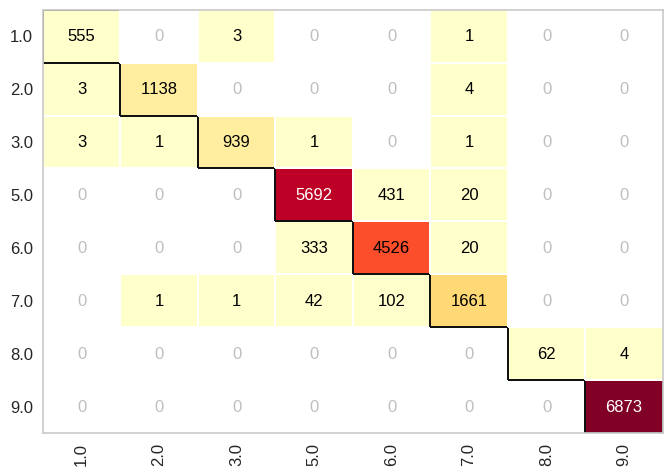

In [ ]:
cm = ConfusionMatrix(random_forest_classifier)
cm.fit(X_train, y_train)
cm.score(X_test,y_test)

In [ ]:
!pip install imbalanced-learn


In [ ]:
print(classification_report(y_test, y_pred))

**Com balanceamento de classes**

<ipython-input-38-c32461cd548d>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=ax[0], palette="viridis")
<ipython-input-38-c32461cd548d>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, ax=ax[1], palette="viridis")


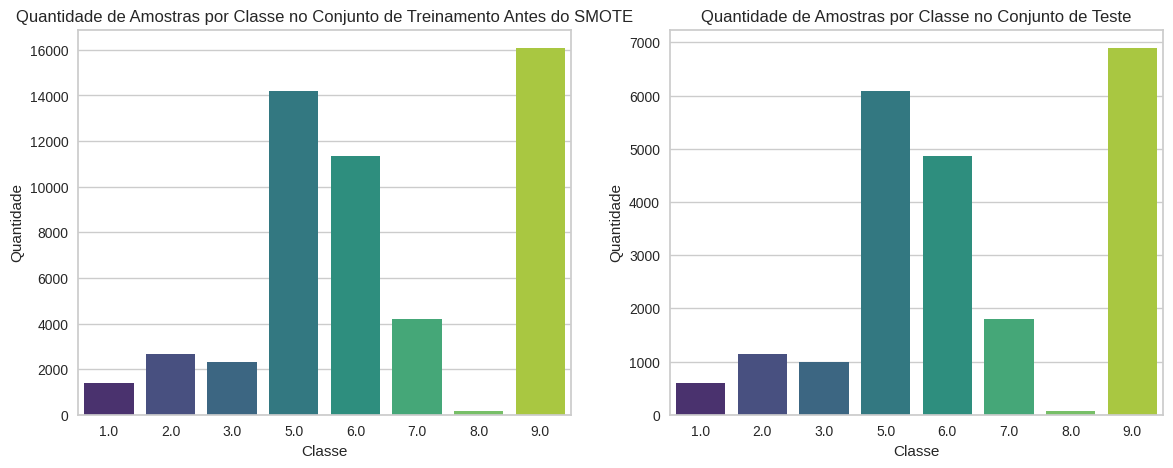

<ipython-input-38-c32461cd548d>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette="viridis")


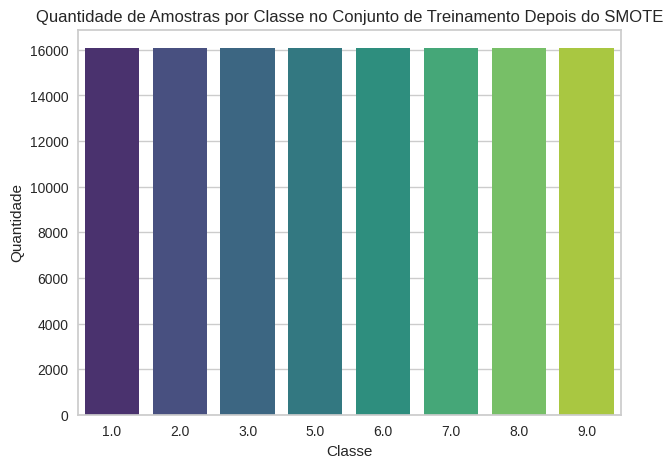

False
Acurácia do Random Forest: 0.9538742918320917


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Verifique e substitua valores NaN em y
#y = np.nan_to_num(y)  # Substituir NaN por 0 ou outro valor dependendo do contexto

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Plot quantidade de amostras por classe antes do SMOTE
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x=y_train, ax=ax[0], palette="viridis")
ax[0].set_title('Quantidade de Amostras por Classe no Conjunto de Treinamento Antes do SMOTE')
ax[0].set_xlabel('Classe')
ax[0].set_ylabel('Quantidade')

sns.countplot(x=y_test, ax=ax[1], palette="viridis")
ax[1].set_title('Quantidade de Amostras por Classe no Conjunto de Teste')
ax[1].set_xlabel('Classe')
ax[1].set_ylabel('Quantidade')

plt.show()

# Aplicar o SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Plot quantidade de amostras por classe depois do SMOTE
plt.figure(figsize=(7, 5))
sns.countplot(x=y_train_resampled, palette="viridis")
plt.title('Quantidade de Amostras por Classe no Conjunto de Treinamento Depois do SMOTE')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

# Treinamento do RandomForestClassifier
random_forest_classifier = RandomForestClassifier(
    n_estimators=100,          # Número de árvores na floresta
    min_samples_leaf=5,        # Número mínimo de amostras em uma folha da árvore
    min_samples_split=2,       # Número mínimo de amostras necessárias para dividir um nó interno
    random_state=42,           # Semente aleatória para reprodução dos resultados
    max_depth=80,              # Profundidade máxima das árvores
)

random_forest_classifier.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de teste
y_pred = random_forest_classifier.predict(X_test)

# Verificação de valores NaN em y_test
print(np.isnan(y_test).any())

# Se houver NaN, substitua por 0
#y_test_filled = np.nan_to_num(y_test)  # Substituir NaN por 0

# Cálculo da acurácia
accuracy_random = accuracy_score(y_test, y_pred)
print("Acurácia do Random Forest:", accuracy_random)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.9952658582089552

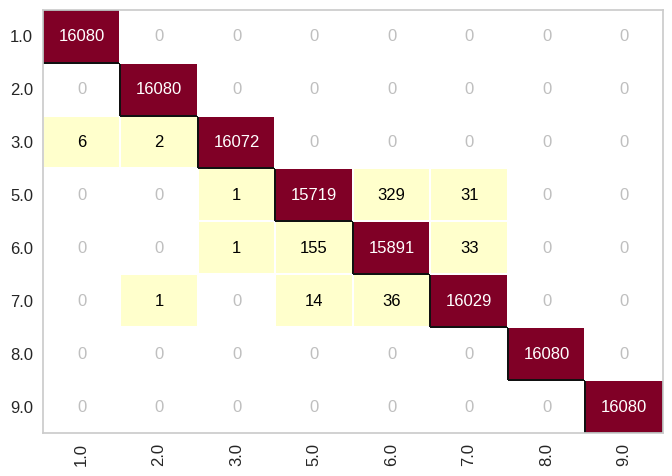

In [ ]:
cm = ConfusionMatrix(random_forest_classifier)
cm.fit(X_train_resampled, y_train_resampled)
cm.score(X_train_resampled, y_train_resampled)

**KNN sem balanceamento**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Criar uma instância do modelo KNN com um determinado número de vizinhos (n_neighbors)
knn_classifier = KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Treinar o modelo
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = knn_classifier.predict(X_test)

In [ ]:
# Avaliar a precisão do modelo
accuracy_knn = accuracy_score(y_test, y_pred)

In [ ]:
print(f'Precisão do modelo KNN: {accuracy_knn}')

Precisão do modelo KNN: 0.9144845429807735


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.9144845429807735

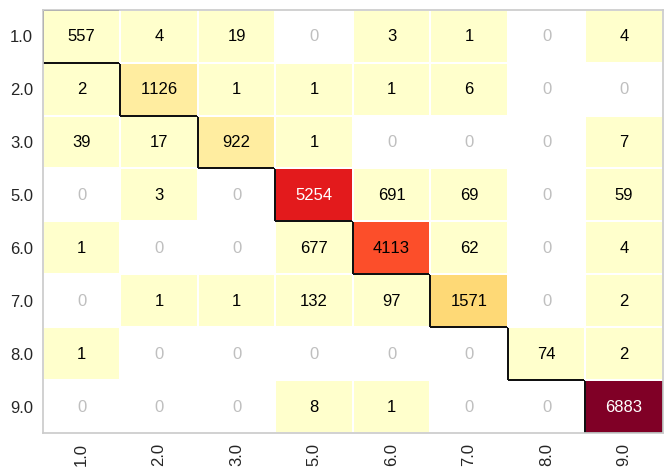

In [ ]:
cm = ConfusionMatrix(knn_classifier)
cm.fit(X_train, y_train)
cm.score(X_test,y_test)

**KNN com balanceamento**

<ipython-input-49-be3b6edbf3d0>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=ax[0], palette="viridis")
<ipython-input-49-be3b6edbf3d0>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, ax=ax[1], palette="viridis")


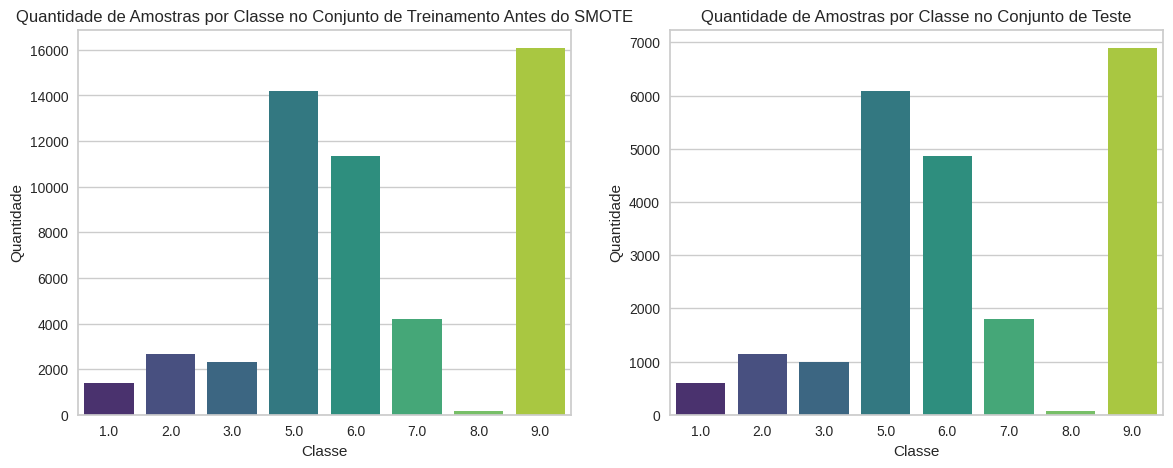

<ipython-input-49-be3b6edbf3d0>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette="viridis")


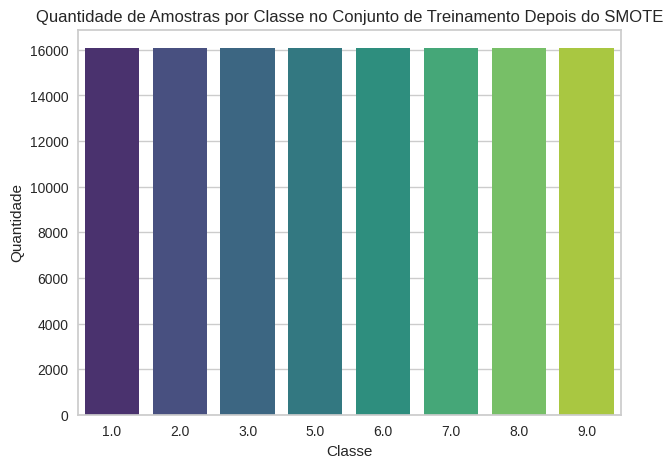

False
Acurácia do KNN: 0.9105589507962707


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Verifique e substitua valores NaN em y
#y = np.nan_to_num(y)  # Substituir NaN por 0 ou outro valor dependendo do contexto

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Plot quantidade de amostras por classe antes do SMOTE
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x=y_train, ax=ax[0], palette="viridis")
ax[0].set_title('Quantidade de Amostras por Classe no Conjunto de Treinamento Antes do SMOTE')
ax[0].set_xlabel('Classe')
ax[0].set_ylabel('Quantidade')

sns.countplot(x=y_test, ax=ax[1], palette="viridis")
ax[1].set_title('Quantidade de Amostras por Classe no Conjunto de Teste')
ax[1].set_xlabel('Classe')
ax[1].set_ylabel('Quantidade')

plt.show()

# Aplicar o SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Plot quantidade de amostras por classe depois do SMOTE
plt.figure(figsize=(7, 5))
sns.countplot(x=y_train_resampled, palette="viridis")
plt.title('Quantidade de Amostras por Classe no Conjunto de Treinamento Depois do SMOTE')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de teste
y_pred = knn_classifier.predict(X_test)

# Verificação de valores NaN em y_test
print(np.isnan(y_test).any())

# Se houver NaN, substitua por 0
#y_test_filled = np.nan_to_num(y_test)  # Substituir NaN por 0

# Cálculo da acurácia
accuracy_random = accuracy_score(y_test, y_pred)
print("Acurácia do KNN:", accuracy_random)


SVM sem balanceamento

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Criar uma instância do modelo SVM

svm_classifier = SVC(kernel='linear',
                     C=1.0,
                     random_state=42)

# Treinar o modelo
svm_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = svm_classifier.predict(X_test)

# Avaliar a precisão do modelo
accuracy_svm = accuracy_score(y_test, y_pred)

print(f'Precisão do modelo SVC: {accuracy_svm}')

Precisão do modelo SVC: 0.8771914172279967


**SVM com balanceamento**

<ipython-input-52-dca222ca77da>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=ax[0], palette="viridis")
<ipython-input-52-dca222ca77da>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, ax=ax[1], palette="viridis")


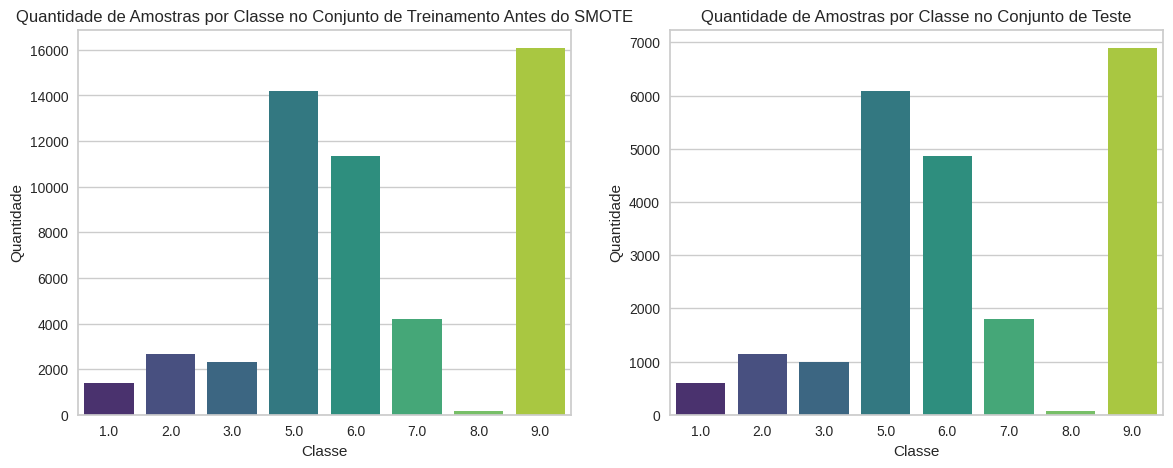

<ipython-input-52-dca222ca77da>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette="viridis")


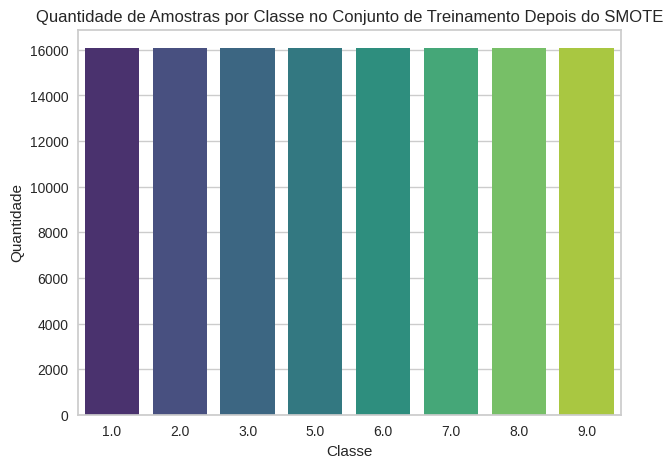

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Verifique e substitua valores NaN em y
#y = np.nan_to_num(y)  # Substituir NaN por 0 ou outro valor dependendo do contexto

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Plot quantidade de amostras por classe antes do SMOTE
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x=y_train, ax=ax[0], palette="viridis")
ax[0].set_title('Quantidade de Amostras por Classe no Conjunto de Treinamento Antes do SMOTE')
ax[0].set_xlabel('Classe')
ax[0].set_ylabel('Quantidade')

sns.countplot(x=y_test, ax=ax[1], palette="viridis")
ax[1].set_title('Quantidade de Amostras por Classe no Conjunto de Teste')
ax[1].set_xlabel('Classe')
ax[1].set_ylabel('Quantidade')

plt.show()

# Aplicar o SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Plot quantidade de amostras por classe depois do SMOTE
plt.figure(figsize=(7, 5))
sns.countplot(x=y_train_resampled, palette="viridis")
plt.title('Quantidade de Amostras por Classe no Conjunto de Treinamento Depois do SMOTE')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

svm_classifier = SVC(kernel='linear',
                     C=1.0,
                     random_state=42)
svm_classifier.fit(X_train_resampled, y_train_resampled)

# Previsões no conjunto de teste
y_pred = svm_classifier.predict(X_test)

# Verificação de valores NaN em y_test
print(np.isnan(y_test).any())

# Se houver NaN, substitua por 0
#y_test_filled = np.nan_to_num(y_test)  # Substituir NaN por 0

# Cálculo da acurácia
accuracy_random = accuracy_score(y_test, y_pred)
print("Acurácia do KNN:", accuracy_random)


**Valores de cada ACCURACES**

OBS: mudar accurance_mlp de acordo como está escrito no código

In [ ]:
accuracy_random
accuracy_svm
accuracy_knn

In [ ]:
metrics_dict = {
    'Random Forest': accuracy_random,
    'SVM': accuracy_svm,
}

df_metrics = pd.DataFrame(list(metrics_dict.items()),
                          columns=['Modelo', 'Métrica'])



plt.bar(df_metrics['Modelo'], df_metrics['Métrica'], color=['blue', 'green', 'orange', 'red'])
plt.title('Métricas dos Modelos')
plt.ylabel('Valor da Métrica')
plt.show()

**Premutação, ou seja, valor com maior importância que determina na classificação**

In [ ]:
from sklearn.inspection import permutation_importance
permutation_importance_results = permutation_importance(random_forest_classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

sorted_idx = permutation_importance_results.importances_mean.argsort()

plt.figure(figsize=(4, 5))

plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])


plt.xlabel("Permutation Importance, random_forest_classifier")

# Exibindo a figura
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
permutation_importance_results = permutation_importance(svm_classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

sorted_idx = permutation_importance_results.importances_mean.argsort()

plt.figure(figsize=(4, 5))

plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx], color= 'yellow')


plt.xlabel("Permutation Importance, svm_classifier")

# Exibindo a figura
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
permutation_importance_results = permutation_importance(knn_classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

sorted_idx = permutation_importance_results.importances_mean.argsort()

plt.figure(figsize=(4, 5))

plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx], color='green')


plt.xlabel("Permutation Importance, knn_classifier")

# Exibindo a figura
plt.show()